# Question 2: Fully Convolutional Networks

In [ ]:
# PyTorch and related libraries
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn import Module, Sequential, Conv2d, UpsamplingBilinear2d
from torch.utils.data import DataLoader, Dataset, TensorDataset

# torchvision for computer vision tasks
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# skimage for image processing
from skimage import io, color
from skimage.transform import resize
from skimage.io import imread

# numpy for numerical operations
import numpy as np

# json for handling JSON data
import json

# os for operating system related tasks
import os

# matplotlib for plotting
import matplotlib.pyplot as plt

# scipy for scientific computing
import scipy
from scipy.spatial import KDTree

# sklearn for machine learning and data analysis
from sklearn import metrics
from sklearn.model_selection import train_test_split

# tqdm for progress bars
from tqdm import tqdm

# warnings for handling warnings
import warnings
warnings.filterwarnings('ignore')

from torchsummary import summary

## Data Loading and Pre-processing:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

# Unzip Dataset
!unzip '/content/drive/MyDrive/dataset.zip'  # Unzip the dataset from Google Drive

def get_files(path):
    files = os.listdir(path)  # List all files in the directory
    files = [os.path.join(path, f) for f in files]  # Join the path with each file name
    return files

def create_dataset(path, image_shape):
    images_filepath = os.path.join(path, 'images')  # Path to images
    masks_filepath = os.path.join(path, 'masks')  # Path to masks

    images_filepaths = get_files(images_filepath)  # Get all image file paths
    masks_filepaths = get_files(masks_filepath)  # Get all mask file paths

    images = []
    masks = []

    # Opening Label2Cmap JSON file
    with open('/content/dataset/label2cmap.json') as json_file:
        label2cmap = json.load(json_file)  # Load the JSON file

    color_map = [label2cmap[labels] for labels in label2cmap]  # Create a color map

    color_tree = KDTree(color_map.copy())  # Create a KDTree for efficient nearest neighbor search

    for image_path in images_filepaths:
        images.append(resize(imread(image_path), image_shape, anti_aliasing = False))  # Resize and append each image

    for mask_path in masks_filepaths:
        mask = resize(imread(mask_path), image_shape, anti_aliasing = False)  # Resize each mask
        mask_labeled = color_tree.query(mask*255)[1]  # Find the nearest color in the color map for each pixel
        masks.append(np.eye(len(color_map))[mask_labeled])  # One-hot encode the labels

    print(f'{len(images)} files found')

    return images,masks  # Return the images and masks

images, masks = create_dataset('/content/dataset', image_shape = (224,224))  # Create the dataset

train_images, test_images, train_masks, test_masks = train_test_split(images,masks,test_size = 0.2)  # Split the dataset into training and testing sets

train_images = np.array(train_images)
train_masks = np.array(train_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

Mounted at /content/drive
Archive:  /content/drive/MyDrive/dataset.zip
   creating: dataset/
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/images/
  inflating: dataset/label2cmap.json  
  inflating: dataset/README.md       
  inflating: dataset/train_test_split.json  
   creating: dataset/masks/
  inflating: dataset/images/2022-08-24 (274).png  
  inflating: dataset/images/2022-08-24 (331).png  
  inflating: dataset/images/2022-08-24 (223).png  
  inflating: dataset/images/2022-08-24 (48).png  
  inflating: dataset/images/2022-08-24 (235).png  
  inflating: dataset/images/2022-08-24 (262).png  
  inflating: dataset/images/2022-08-24 (327).png  
  inflating: dataset/images/2022-08-24 (130).png  
  inflating: dataset/images/2022-08-24 (72).png  
  inflating: dataset/images/2022-08-24 (219).png  
  inflating: dataset/images/2022-08-24 (167).png  
  inflating: dataset/images/2022-08-24 (25).png  
  inflating: dataset/images/2022-08-2

In [ ]:
# Convert NumPy arrays to PyTorch tensors
images_train_tensor = torch.from_numpy(train_images,).to(torch.float)
masks_train_tensor = torch.from_numpy(train_masks,).to(torch.float)
images_test_tensor = torch.from_numpy(test_images,).to(torch.float)
masks_test_tensor = torch.from_numpy(test_masks,).to(torch.float)

print(f'Training Images : {images_train_tensor.size()}')
print(f'Training Masks :{masks_train_tensor.size()}')
print(f'Testing Images :{images_test_tensor.size()}')
print(f'Testing Masks :{masks_test_tensor.size()}')

# Create a PyTorch dataset
train_dataset = TensorDataset(images_train_tensor, masks_train_tensor)
test_dataset = TensorDataset(images_test_tensor, masks_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Training Images : torch.Size([238, 224, 224, 3])
Training Masks :torch.Size([238, 224, 224, 9])
Testing Images :torch.Size([60, 224, 224, 3])
Testing Masks :torch.Size([60, 224, 224, 9])


In [ ]:
# Load pretrained model
resnet18 = models.resnet18(pretrained=True)

#freeze the resnet18 Layers
for param in resnet18.parameters():
    param.requires_grad = False

# Device will determine whether to run the training on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


## With Skip Connections:

### 1. Model:

In [ ]:
class ResNet_segmentor(nn.Module):
  def __init__(self, original_model):
      super(ResNet_segmentor, self).__init__()
      self.conv1 = original_model.conv1
      self.bn1 = original_model.bn1
      self.relu = original_model.relu
      self.maxpool = original_model.maxpool

      self.layer1 = original_model.layer1
      self.layer2 = original_model.layer2
      self.layer3 = original_model.layer3
      self.layer4 = original_model.layer4

      self.delayer1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)

      self.bn2 = nn.BatchNorm2d(256)
      self.delayer2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)

      self.bn3 = nn.BatchNorm2d(128)
      self.delayer3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

      self.bn4 = nn.BatchNorm2d(64)

      self.superdelayer = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=4)
      self.bn5 = nn.BatchNorm2d(64)

      self.sample = nn.Conv2d(64, 9, kernel_size=1, stride=1)

  def forward(self, x):
    # Initial layers
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    # ResNet blocks
    x1 = self.layer1(x)  # First block of ResNet
    x2 = self.layer2(x1)  # Second block of ResNet
    x3 = self.layer3(x2)  # Third block of ResNet
    x4 = self.layer4(x3)  # Fourth block of ResNet

    # Upsampling and addition (skip connection)

    x4_upsampled = self.bn2(self.relu(self.delayer1(x4)))  # Upsample x4
    x_3 = x3 + x4_upsampled  # Add upsampled x4 and x3

    x3_upsampled = self.bn3(self.relu(self.delayer2(x_3)))  # Upsample x_3
    x_2 = x2 + x3_upsampled  # Add upsampled x_3 and x2

    x2_upsampled = self.bn4(self.relu(self.delayer3(x_2)))  # Upsample x_2
    x_1 = x1 + x2_upsampled  # Add upsampled x_2 and x1

    # Final layers
    out1 = self.bn5(self.relu(self.superdelayer(x_1)))  # Upsample x_1
    out = self.sample(out1)  # Apply final convolution to get the output

    return out

### 2. Training:

In [ ]:
# Training:
model = ResNet_segmentor(resnet18)

model = model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

batch_size = 32
num_epochs = 50
loss_values_skip = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader):

        images=images.permute(0, 3, 1, 2).to(device)
        masks=masks.permute(0, 3, 1, 2).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_function(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    loss_values_skip.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

100%|██████████| 15/15 [00:02<00:00,  5.33it/s]


Epoch 1/50, Loss: 1.678661126048625


100%|██████████| 15/15 [00:01<00:00, 13.47it/s]


Epoch 2/50, Loss: 1.0100741606800496


100%|██████████| 15/15 [00:01<00:00, 12.45it/s]


Epoch 3/50, Loss: 0.7944130509340462


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


Epoch 4/50, Loss: 0.6682999785206899


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


Epoch 5/50, Loss: 0.4182527809082961


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


Epoch 6/50, Loss: 0.3342259360962555


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


Epoch 7/50, Loss: 0.2586690477964257


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


Epoch 8/50, Loss: 0.22382964644612385


100%|██████████| 15/15 [00:01<00:00, 13.73it/s]


Epoch 9/50, Loss: 0.21993496412990474


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


Epoch 10/50, Loss: 0.20934581456064177


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


Epoch 11/50, Loss: 0.1784158867447316


100%|██████████| 15/15 [00:01<00:00, 13.28it/s]


Epoch 12/50, Loss: 0.18701527749790864


100%|██████████| 15/15 [00:01<00:00, 12.27it/s]


Epoch 13/50, Loss: 0.19267932632390192


100%|██████████| 15/15 [00:01<00:00, 12.19it/s]


Epoch 14/50, Loss: 0.15334824491448762


100%|██████████| 15/15 [00:01<00:00, 13.41it/s]


Epoch 15/50, Loss: 0.1374466769209429


100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


Epoch 16/50, Loss: 0.13203303102685623


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


Epoch 17/50, Loss: 0.14082518194903845


100%|██████████| 15/15 [00:01<00:00, 13.01it/s]


Epoch 18/50, Loss: 0.13963290498036296


100%|██████████| 15/15 [00:01<00:00, 14.04it/s]


Epoch 19/50, Loss: 0.11714352930293363


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


Epoch 20/50, Loss: 0.13339166155382365


100%|██████████| 15/15 [00:01<00:00, 12.95it/s]


Epoch 21/50, Loss: 0.12665261597443028


100%|██████████| 15/15 [00:01<00:00, 12.35it/s]


Epoch 22/50, Loss: 0.11784666901876946


100%|██████████| 15/15 [00:01<00:00, 12.45it/s]


Epoch 23/50, Loss: 0.11702836148378228


100%|██████████| 15/15 [00:01<00:00, 12.61it/s]


Epoch 24/50, Loss: 0.09542879462242126


100%|██████████| 15/15 [00:01<00:00, 12.56it/s]


Epoch 25/50, Loss: 0.09068015562135633


100%|██████████| 15/15 [00:01<00:00, 12.60it/s]


Epoch 26/50, Loss: 0.08192950117738307


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


Epoch 27/50, Loss: 0.07797533474048647


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


Epoch 28/50, Loss: 0.0854306066361796


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


Epoch 29/50, Loss: 0.08789797878565908


100%|██████████| 15/15 [00:01<00:00, 12.94it/s]


Epoch 30/50, Loss: 0.07771687829444389


100%|██████████| 15/15 [00:01<00:00, 13.28it/s]


Epoch 31/50, Loss: 0.07097602767102859


100%|██████████| 15/15 [00:01<00:00, 13.28it/s]


Epoch 32/50, Loss: 0.07443951552405077


100%|██████████| 15/15 [00:01<00:00, 13.42it/s]


Epoch 33/50, Loss: 0.06621850178647443


100%|██████████| 15/15 [00:01<00:00, 13.25it/s]


Epoch 34/50, Loss: 0.06613796210589529


100%|██████████| 15/15 [00:01<00:00, 12.74it/s]


Epoch 35/50, Loss: 0.05993132230614414


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Epoch 36/50, Loss: 0.0607716302473505


100%|██████████| 15/15 [00:01<00:00, 13.09it/s]


Epoch 37/50, Loss: 0.062378189456062154


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


Epoch 38/50, Loss: 0.06374169394624334


100%|██████████| 15/15 [00:01<00:00, 13.19it/s]


Epoch 39/50, Loss: 0.056434170882992386


100%|██████████| 15/15 [00:01<00:00, 13.28it/s]


Epoch 40/50, Loss: 0.05953858104072699


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


Epoch 41/50, Loss: 0.06088335780786867


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


Epoch 42/50, Loss: 0.059842691201121866


100%|██████████| 15/15 [00:01<00:00, 13.41it/s]


Epoch 43/50, Loss: 0.057681875945139335


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


Epoch 44/50, Loss: 0.05723820927263308


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


Epoch 45/50, Loss: 0.05197516612771178


100%|██████████| 15/15 [00:01<00:00, 12.79it/s]


Epoch 46/50, Loss: 0.05331999013403885


100%|██████████| 15/15 [00:01<00:00, 12.52it/s]


Epoch 47/50, Loss: 0.050182261199009516


100%|██████████| 15/15 [00:01<00:00, 12.89it/s]


Epoch 48/50, Loss: 0.05182327474115275


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Epoch 49/50, Loss: 0.04968985339172748


100%|██████████| 15/15 [00:01<00:00, 13.23it/s]

Epoch 50/50, Loss: 0.047291391693493896


### 3. Testing and Evaluation:

In [ ]:
# Evaluation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

images_test = images_test_tensor.permute(0,3,1,2).to(device)
outputs = model(images_test).permute(0,2,3,1)

segmented_maps = torch.argmax(outputs, dim = 3).to(torch.device('cpu'))
segmented_maps = segmented_maps.numpy()

actual_masks = torch.argmax(masks_test_tensor,dim=3)
actual_masks = actual_masks.numpy()

# Calculating per pixel accuracy
per_pixel_accuracy = np.sum(actual_masks == segmented_maps)/(np.prod(actual_masks.shape))

# Calculating mean IoU
mean_iou_list =[]
for i in range(len(segmented_maps)):
  iou_list = []
  for label in range(9):

    actual = actual_masks[i]==label
    segmented = segmented_maps[i]==label
    intersection = segmented[actual==True]

    union = np.sum(actual) + np.sum(segmented) - np.sum(intersection)

    if union!=0:
      iou = np.sum(intersection)/union
      iou_list.append(iou)

  mean_iou_list.append(np.mean(iou_list))

print(f"Per pixel accuracy is {per_pixel_accuracy}")
print(f"Mean IoU is {np.mean(mean_iou_list)}")

Per pixel accuracy is 0.9649208120748299
Mean IoU is 0.32518176006036287


### 4. Display Image:

(-0.5, 223.5, 223.5, -0.5)

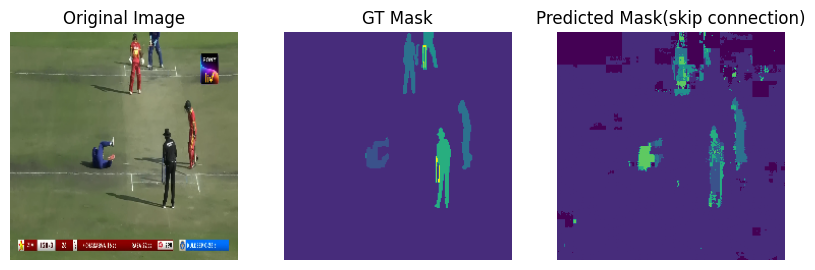

In [ ]:
random_index=10

sample_image = images_test_tensor[random_index]
actual_mask = torch.argmax(masks_test_tensor[random_index], dim=2)

segmented_mask = torch.argmax(model(sample_image.unsqueeze(0).permute(0,3,1,2).to(device)).permute(0,2,3,1).squeeze(0),dim=2).to(torch.device('cpu'))

plt.figure(figsize = (10,10))

plt.subplot(1,3,1)
plt.imshow(sample_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(actual_mask, vmin=0, vmax=8)
plt.title('GT Mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(segmented_mask, vmin=0, vmax=8)
plt.title('Predicted Mask(skip connection)')
plt.axis('off')

## Without Skip connection:

### 1. Model:

In [ ]:
class ResNet_segmentor_noskip(nn.Module):
  def __init__(self, original_model):
      super(ResNet_segmentor_noskip, self).__init__()
      self.conv1 = original_model.conv1
      self.bn1 = original_model.bn1
      self.relu = original_model.relu
      self.maxpool = original_model.maxpool

      self.layer1 = original_model.layer1
      self.layer2 = original_model.layer2
      self.layer3 = original_model.layer3
      self.layer4 = original_model.layer4

      self.delayer1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)

      self.bn2 = nn.BatchNorm2d(256)
      self.delayer2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)

      self.bn3 = nn.BatchNorm2d(128)
      self.delayer3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

      self.bn4 = nn.BatchNorm2d(64)

      self.superdelayer = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=4)
      self.bn5 = nn.BatchNorm2d(64)

      self.sample = nn.Conv2d(64, 9, kernel_size=1, stride=1)

  def forward(self, x):
    # Initial layers
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    # ResNet blocks
    x1 = self.layer1(x)  # First block of ResNet
    x2 = self.layer2(x1)  # Second block of ResNet
    x3 = self.layer3(x2)  # Third block of ResNet
    x4 = self.layer4(x3)  # Fourth block of ResNet

    # Upsampling and addition (skip connection)

    x4_upsampled = self.bn2(self.relu(self.delayer1(x4)))  # Upsample x4

    x3_upsampled = self.bn3(self.relu(self.delayer2(x4_upsampled)))  # Upsample x_3

    x2_upsampled = self.bn4(self.relu(self.delayer3(x3_upsampled)))  # Upsample x_2

    # Final layers
    out1 = self.bn5(self.relu(self.superdelayer(x2_upsampled)))  # Upsample x_1
    out = self.sample(out1)  # Apply final convolution to get the output

    return out

### 2. Training:

In [ ]:
# Training:
model_noskip = ResNet_segmentor_noskip(resnet18)

model_noskip = model_noskip.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_noskip.parameters(), lr = 0.001)

batch_size = 32
num_epochs = 50
loss_values_noskip = []

for epoch in range(num_epochs):
    model_noskip.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader):

        images=images.permute(0, 3, 1, 2).to(device)
        masks=masks.permute(0, 3, 1, 2).to(device)

        optimizer.zero_grad()
        outputs = model_noskip(images)

        loss = loss_function(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    loss_values_noskip.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

100%|██████████| 15/15 [00:01<00:00, 11.70it/s]


Epoch 1/50, Loss: 1.8091182778863346


100%|██████████| 15/15 [00:01<00:00, 13.23it/s]


Epoch 2/50, Loss: 1.1162636931202992


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


Epoch 3/50, Loss: 0.8236181735992432


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


Epoch 4/50, Loss: 0.6203048376976943


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


Epoch 5/50, Loss: 0.7181081361129504


100%|██████████| 15/15 [00:01<00:00, 13.43it/s]


Epoch 6/50, Loss: 0.5241500119201276


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


Epoch 7/50, Loss: 0.4277842563240468


100%|██████████| 15/15 [00:01<00:00, 13.08it/s]


Epoch 8/50, Loss: 0.3536409415116831


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


Epoch 9/50, Loss: 0.46600673003356996


100%|██████████| 15/15 [00:01<00:00, 13.41it/s]


Epoch 10/50, Loss: 0.33220505113361265


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


Epoch 11/50, Loss: 0.408354823078428


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


Epoch 12/50, Loss: 0.3075377938627195


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


Epoch 13/50, Loss: 0.2565182242072931


100%|██████████| 15/15 [00:01<00:00, 13.29it/s]


Epoch 14/50, Loss: 0.2742815618755437


100%|██████████| 15/15 [00:01<00:00, 12.99it/s]


Epoch 15/50, Loss: 0.23802775457626632


100%|██████████| 15/15 [00:01<00:00, 13.07it/s]


Epoch 16/50, Loss: 0.2232893386057445


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


Epoch 17/50, Loss: 0.23631620770242034


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


Epoch 18/50, Loss: 0.22351706654083828


100%|██████████| 15/15 [00:01<00:00, 12.50it/s]


Epoch 19/50, Loss: 0.2979689457085954


100%|██████████| 15/15 [00:01<00:00, 12.73it/s]


Epoch 20/50, Loss: 0.2318054144622899


100%|██████████| 15/15 [00:01<00:00, 12.18it/s]


Epoch 21/50, Loss: 0.2387612296753571


100%|██████████| 15/15 [00:01<00:00, 12.29it/s]


Epoch 22/50, Loss: 0.22209445869221406


100%|██████████| 15/15 [00:01<00:00, 12.20it/s]


Epoch 23/50, Loss: 0.2022268097190296


100%|██████████| 15/15 [00:01<00:00, 13.03it/s]


Epoch 24/50, Loss: 0.22020697142897533


100%|██████████| 15/15 [00:01<00:00, 13.29it/s]


Epoch 25/50, Loss: 0.2224108648149907


100%|██████████| 15/15 [00:01<00:00, 13.27it/s]


Epoch 26/50, Loss: 0.1911214575046251


100%|██████████| 15/15 [00:01<00:00, 13.22it/s]


Epoch 27/50, Loss: 0.17856272153493738


100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


Epoch 28/50, Loss: 0.18772354171055705


100%|██████████| 15/15 [00:01<00:00, 13.07it/s]


Epoch 29/50, Loss: 0.17533145118661286


100%|██████████| 15/15 [00:01<00:00, 13.00it/s]


Epoch 30/50, Loss: 0.17160600962258188


100%|██████████| 15/15 [00:01<00:00,  8.30it/s]


Epoch 31/50, Loss: 0.17470189240299352


100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Epoch 32/50, Loss: 0.16051694425214239


100%|██████████| 15/15 [00:01<00:00, 13.39it/s]


Epoch 33/50, Loss: 0.17569667626829708


100%|██████████| 15/15 [00:01<00:00, 13.39it/s]


Epoch 34/50, Loss: 0.16149836315327332


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


Epoch 35/50, Loss: 0.15299854033133564


100%|██████████| 15/15 [00:01<00:00, 13.16it/s]


Epoch 36/50, Loss: 0.14985842627136647


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


Epoch 37/50, Loss: 0.14773445507558455


100%|██████████| 15/15 [00:01<00:00, 13.02it/s]


Epoch 38/50, Loss: 0.15376435120065673


100%|██████████| 15/15 [00:01<00:00, 13.07it/s]


Epoch 39/50, Loss: 0.14354283256190165


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


Epoch 40/50, Loss: 0.14087797839100621


100%|██████████| 15/15 [00:01<00:00, 12.80it/s]


Epoch 41/50, Loss: 0.1328338352071137


100%|██████████| 15/15 [00:01<00:00, 12.74it/s]


Epoch 42/50, Loss: 0.13033185999433533


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


Epoch 43/50, Loss: 0.13070504442483438


100%|██████████| 15/15 [00:01<00:00, 13.02it/s]


Epoch 44/50, Loss: 0.16267317683756852


100%|██████████| 15/15 [00:01<00:00, 13.18it/s]


Epoch 45/50, Loss: 0.1470647455513978


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


Epoch 46/50, Loss: 0.1361772192000341


100%|██████████| 15/15 [00:01<00:00, 13.12it/s]


Epoch 47/50, Loss: 0.12471303443948761


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


Epoch 48/50, Loss: 0.1339624860957891


100%|██████████| 15/15 [00:01<00:00, 12.71it/s]


Epoch 49/50, Loss: 0.1310749193575202


100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

Epoch 50/50, Loss: 0.12452148138975896


###3. Testing and Evaluation:

In [ ]:
# Evaluation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

images_test = images_test_tensor.permute(0,3,1,2).to(device)
outputs = model_noskip(images_test).permute(0,2,3,1)

segmented_maps = torch.argmax(outputs, dim = 3).to(torch.device('cpu'))
segmented_maps = segmented_maps.numpy()

actual_masks = torch.argmax(masks_test_tensor,dim=3)
actual_masks = actual_masks.numpy()

# Calculating per pixel accuracy
per_pixel_accuracy = np.sum(actual_masks == segmented_maps)/(np.prod(actual_masks.shape))

# Calculating mean IoU
mean_iou_list =[]
for i in range(len(segmented_maps)):
  iou_list = []
  for label in range(9):

    actual = actual_masks[i]==label
    segmented = segmented_maps[i]==label
    intersection = segmented[actual==True]

    union = np.sum(actual) + np.sum(segmented) - np.sum(intersection)

    if union!=0:
      iou = np.sum(intersection)/union
      iou_list.append(iou)

  mean_iou_list.append(np.mean(iou_list))

print(f"Per pixel accuracy is {per_pixel_accuracy}")
print(f"Mean IoU is {np.mean(mean_iou_list)}")

Per pixel accuracy is 0.92236328125
Mean IoU is 0.20420327908070754


###4. Display:

(-0.5, 223.5, 223.5, -0.5)

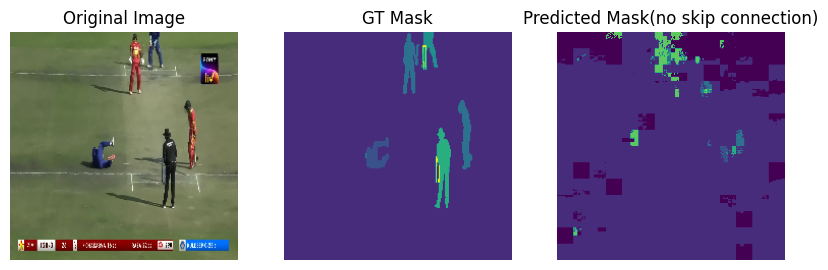

In [ ]:
random_index=10

sample_image = images_test_tensor[random_index]
actual_mask = torch.argmax(masks_test_tensor[random_index], dim=2)

segmented_mask = torch.argmax(model_noskip(sample_image.unsqueeze(0).permute(0,3,1,2).to(device)).permute(0,2,3,1).squeeze(0),dim=2).to(torch.device('cpu'))

plt.figure(figsize = (10,10))

plt.subplot(1,3,1)
plt.imshow(sample_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(actual_mask, vmin=0, vmax=8)
plt.title('GT Mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(segmented_mask, vmin=0, vmax=8)
plt.title('Predicted Mask(no skip connection)')
plt.axis('off')

## Comparison:

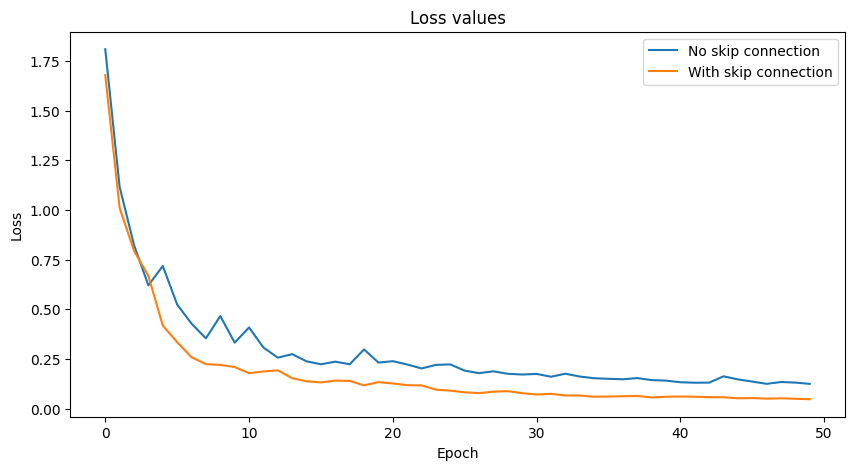

In [ ]:
def plot_loss_values(loss_values_noskip, loss_values_skip):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values_noskip, label='No skip connection')
    plt.plot(loss_values_skip, label='With skip connection')
    plt.title('Loss values')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_loss_values(loss_values_noskip, loss_values_skip)